### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report

### EDA and Data Preprocessing

In [2]:
# Function to clean tweet text
def clean_text(text):
    text = str(text) if text is not None else '' # Convert to string, handle None
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Function to generate a word cloud
def generate_wordcloud(data):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Function to plot sentiment distribution
def plot_sentiment_distribution(df, title):
    sentiment_count = df['sentiment'].value_counts()
    plt.figure(figsize=(6, 4))
    sentiment_count.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('Counts')
    plt.show()

### Load datasets

In [3]:
# Train
train_df = pd.read_csv('tweettrain.csv')
train_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [4]:
# Test
test_df = pd.read_csv('tweettest.csv')
test_df

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative
3530,416863ce47,All alone in this old house again. Thanks for...,positive
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive


In [5]:
# Clean text data
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)


Word Cloud for Positive Sentiment:


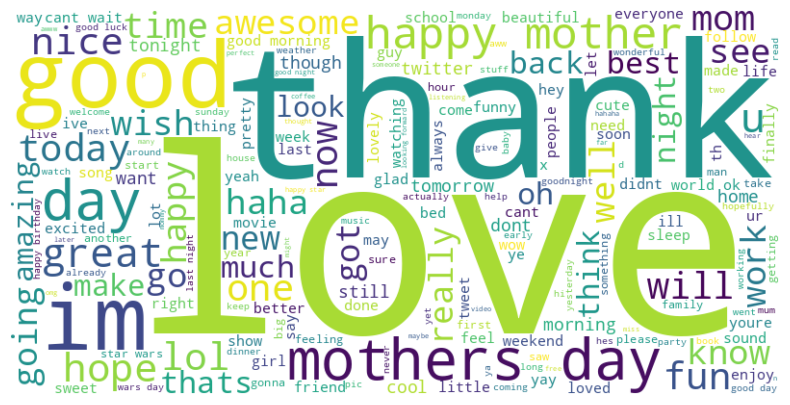

In [6]:
# Filter text based on sentiment
positive_text = train_df[train_df['sentiment'] == 'positive']['text']
negative_text = train_df[train_df['sentiment'] == 'negative']['text']
neutral_text = train_df[train_df['sentiment'] == 'neutral']['text']

# Generate word clouds for each sentiment
print("\nWord Cloud for Positive Sentiment:")
generate_wordcloud(positive_text)


Word Cloud for Negative Sentiment:


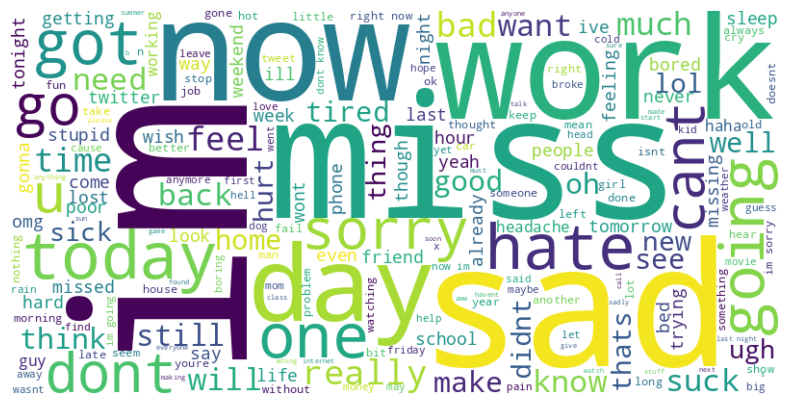

In [7]:
print("\nWord Cloud for Negative Sentiment:")
generate_wordcloud(negative_text)


Word Cloud for Neutral Sentiment:


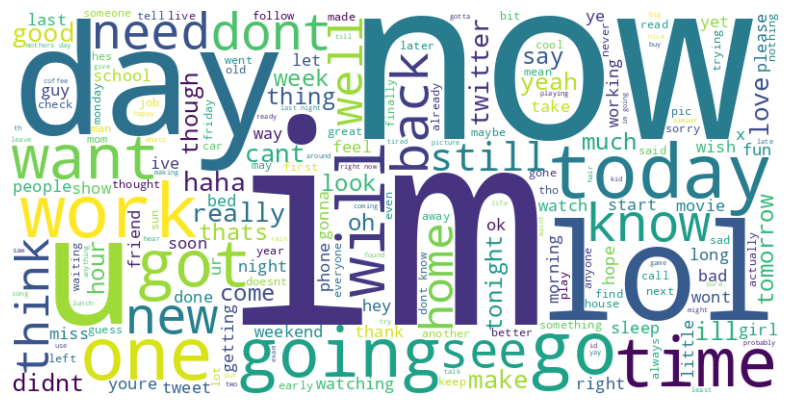

In [8]:
print("\nWord Cloud for Neutral Sentiment:")
generate_wordcloud(neutral_text)


Sentiment Distribution in Training Data:


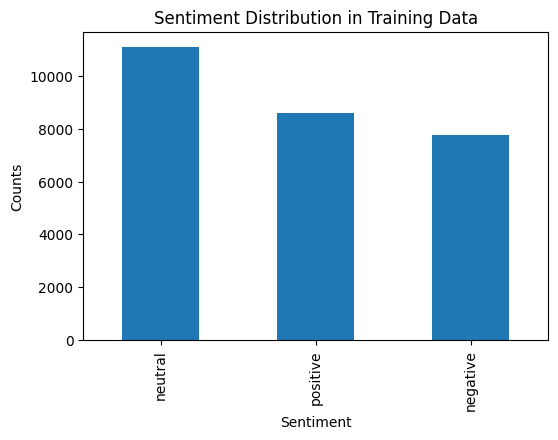

In [9]:
# Sentiment Distribution in Training Data
print("\nSentiment Distribution in Training Data:")
plot_sentiment_distribution(train_df, 'Sentiment Distribution in Training Data')


Sentiment Distribution in Test Data:


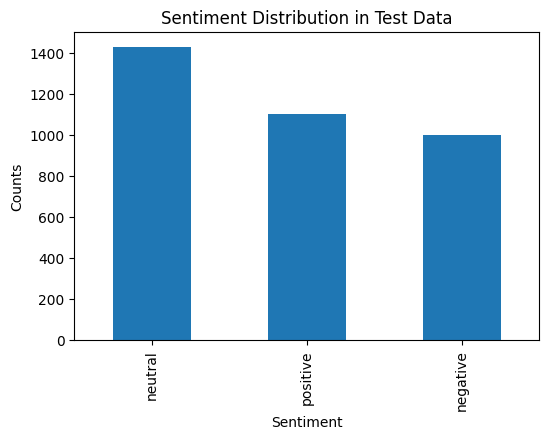

In [10]:
# Sentiment Distribution in Test Data
print("\nSentiment Distribution in Test Data:")
plot_sentiment_distribution(test_df, 'Sentiment Distribution in Test Data')

In [11]:
# Tokenization and vectorization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

In [12]:
# Pad sequences
max_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

### Build the LSTM model

In [13]:
# Model parameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
lstm_units = 64
num_classes = 3

# Build the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           2675800   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 2718235 (10.37 MB)
Trainable params: 2718235 (10.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Convert sentiments to one-hot encoded labels
train_labels = pd.get_dummies(train_df['sentiment']).values

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(
    train_padded,
    train_labels,
    epochs=100,  # High epoch limit; EarlyStopping will handle the actual number
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
687/687 [==============================] - 51s 70ms/step - loss: 0.9148 - accuracy: 0.5512 - val_loss: 0.7576 - val_accuracy: 0.6760
Epoch 2/100
687/687 [==============================] - 58s 85ms/step - loss: 0.6215 - accuracy: 0.7533 - val_loss: 0.7071 - val_accuracy: 0.6973
Epoch 3/100
687/687 [==============================] - 51s 74ms/step - loss: 0.4475 - accuracy: 0.8342 - val_loss: 0.7293 - val_accuracy: 0.6946
Epoch 4/100
687/687 [==============================] - 56s 82ms/step - loss: 0.3222 - accuracy: 0.8909 - val_loss: 0.8441 - val_accuracy: 0.6900
Epoch 5/100
687/687 [==============================] - 52s 75ms/step - loss: 0.2424 - accuracy: 0.9187 - val_loss: 0.9274 - val_accuracy: 0.6795
Epoch 6/100
687/687 [==============================] - 49s 71ms/step - loss: 0.1901 - accuracy: 0.9364 - val_loss: 1.0523 - val_accuracy: 0.6751
Epoch 7/100
687/687 [==============================] - 48s 70ms/step - loss: 0.1586 - accuracy: 0.9458 - val_loss: 1.1686 - val_ac

In [15]:
# Predict on test data
test_predictions = model.predict(test_padded)

111/111 [==============================] - 2s 9ms/step


In [16]:
# Convert probabilities to class labels
test_labels_pred = np.argmax(test_predictions, axis=1)

In [17]:
# Prepare true labels for test data
test_labels_true = pd.get_dummies(test_df['sentiment']).values
test_labels_true = np.argmax(test_labels_true, axis=1)

### Evaluate the Model

In [18]:
# Calculate accuracy
accuracy = accuracy_score(test_labels_true, test_labels_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6966610073571025


In [19]:
# Generate classification report
report = classification_report(test_labels_true, test_labels_pred, target_names=['positive', 'negative', 'neutral'])
print(report)

              precision    recall  f1-score   support

    positive       0.69      0.70      0.70      1001
    negative       0.63      0.71      0.67      1430
     neutral       0.82      0.67      0.74      1103

    accuracy                           0.70      3534
   macro avg       0.71      0.70      0.70      3534
weighted avg       0.71      0.70      0.70      3534

